# 0. Preamble

## 0.1 Imports

In [43]:
import json
import os
import numpy as np
from scipy import ndimage
from scipy.misc import imresize
import csv
import random
from itertools import product as iterprod
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score, precision_recall_curve
from keras.layers import Convolution2D, MaxPooling2D, Input,ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential, Model, model_from_json
from keras.layers.advanced_activations import LeakyReLU
from keras.applications.vgg16 import VGG16, decode_predictions
from keras.applications.vgg19 import VGG19, decode_predictions
from keras.regularizers import l1,l2,l1l2
from matplotlib import pyplot as plt

## 0.2 Function definitions

In [2]:
#functions

def histofilter(images_filtero):
    histog=np.zeros(numb_ing)
    for ii in images_filtero:
        histog+=img_labels[ii][1]
    return histog

def sieve(images_filtero):
    histemp=histofilter(images_filtero)
    histemp=list(histemp)+[len(images_filtero)-min(histemp)]
    indsort=sorted(range(len(histemp)), key=lambda k: histemp[k])
    histemp=[int(round(ii/min(histemp))) for ii in histemp]
    numin=len(indsort)-1
    newfiltero=[]
    for ii in images_filtero:
        pop=img_labels[ii][1]
        i=0
        while i<numin and pop[indsort[i]]==0.:
            i+=1
        if random.randint(1,histemp[indsort[i]])==1:
            newfiltero+=[ii]
    return newfiltero

def precrec(x_set,y_set,model,modif=None,verbose=1):
    num=len(y_set[0])
    prec=[[] for i in range(num)]
    rec=[[] for i in range(num)]
    thres=[[] for i in range(num)]
    #auc=[0. for i in range(num)]
    yhat=model.predict(x_set,verbose)
    if modif is not None:
        yhat=modif(yhat)
    if len(yhat)==2:
        yhat=yhat[0]
    for i in range(num):
        prec[i],rec[i],thres[i]=np.array(precision_recall_curve(y_set[:,i],yhat[:,i]))
        #auc[i]=roc_auc_score(y_set[:,i],yhat[:,i])
        plt.plot(rec[i],prec[i])
    plt.show()
    return prec, rec, thres

def roccurveauc(x_set,y_set,model,verbose=1):
    num=len(y_set[0])
    fpr=[[] for i in range(num)]
    tpr=[[] for i in range(num)]
    thres=[[] for i in range(num)]
    auc=[0. for i in range(num)]
    try:
        yhat=model.predict(x_set,verbose)
    except:
        yhat=model.predict(x_set)
    if len(yhat)==2:
        yhat=yhat[0]
    for i in range(num):
        fpr[i],tpr[i],thres[i]=np.array(roc_curve(y_set[:,i],yhat[:,i]))
        auc[i]=roc_auc_score(y_set[:,i],yhat[:,i])
        plt.plot(fpr[i],tpr[i])
    plt.show()
    return auc, fpr, tpr, thres

def f1scoretuning(x,y,model,modif=None):
    prec,rec,thres=precrec(x,y,model,modif)
    tune=[]
    maxf1=[]
    for pp,rr,tt in zip(prec,rec,thres):
        f1sc_arr=[]
        for ppj,rrj in zip(pp,rr):
            if (ppj+rrj)==0.:
                f1sc_arr+=[0.]
            else:
                f1sc_arr+=[2*ppj*rrj/(ppj+rrj)]
        tune+=[tt[np.argmax(f1sc_arr)]]
        maxf1+=[max(f1sc_arr)]
    return tune,maxf1

def bayup(yhat):
    temp=[]
    for ii in yhat:
        qq=np.array([sum(pij[i]*ii) for i in range(numb_ing)])
        qq=qq*sum(list(ii))/sum(qq)
        temp+=[qq]
    return np.array(temp)

def bayuplin(yhat):
    temp=[]
    for ii in yhat:
        qq=np.array([sum(pij[i]*ii) for i in range(numb_ing)])
        temp+=[qq]
    return np.array(temp)

def visualtest(nn,predD,thres):
    yhat=predD
    retr=list(ret_test[nn])
    ingret=ingrototret[retr[0]]
    print('Recipe id, image path, and recipe name:\n',retr+[ingret[0]])
    print('"Truth":',ingret[1:] )
    if len(yhat)!=2:
        print('Predicted:', [ingdict[i] for i,ii in enumerate(yhat[nn]) if ii>thres[i]])
    else:
        print('Predicted:',[[catgdict[ii] for ii in np.argsort(yhat[1][nn])[-1:]][0],
                            [ingdict[i] for i,ii in enumerate(yhat[0][nn]) if ii>thres[i]]])
    plt.imshow(ndimage.imread(homedir+'/'+retr[1])[13:-13,13:-13,:])
    plt.show()
    return
    
def visualtest_man(img_name,model,thres):
    img_in=ndimage.imread(scriptscratchdir+'/'+img_name)
    img_out=modelvggc.predict(np.array([imresize(img_in,(224,224,3))]))
    yhat=model.predict(np.array(img_out))
    if len(yhat)!=2:
        print('Predicted:', [ingdict[i] for i,ii in enumerate(yhat[0]) if ii>thres[i]])
    else:
        print('Predicted:',[[catgdict[ii] for ii in np.argsort(yhat[1][0])[-1:]][0],
                            [ingdict[i] for i,ii in enumerate(yhat[0][0]) if ii>thres[i]]])
    plt.imshow(img_in)
    plt.show()
    return

def scores(y,yhat,thres):
    scores=[0,0,0,0]
    for ii in zip(yhat,y):
        temp=2*np.ceil(ii[0]-tunered)-ii[1]
        for jj in temp:
            scores[int(jj)]+=1
    fp=scores[2]
    fn=scores[3]
    tp=scores[1]
    tn=scores[0]
    rec=tp/(tp+fn)
    prec=tp/(tp+fp)
    f1=2*rec*prec/(rec+prec)
    return rec,prec,f1

## 0.3 defining directories

In [3]:
homedir='/Users/Maxos/Desktop/Insight_stuff/bigsnippyrepo/IseeWHATyouEAT/allrecipesscrepo'
scriptscratchdir='/Users/Maxos/Desktop/Insight_stuff/bigsnippyrepo/IseeWHATyouEAT'

#homedir contains the json and csv files, plus a directory per each recipe named after the recipe_id, in turn containing 
#the scraped jpg images, also the folder img_preprocessed contains the same structure of recipe folders but each folder 
#now has inside the output of VGG16

#scriptscratchdir contains this notebook and all auxiliary files etc

# 1. Label preprocessing. Hello! Welcome! We handle ingredients/categories/recipes lists here and save the results into files that can be loaded at chapter 2.!!

## 1.1 Defining a dictionary of ingredients and labelling the recipes by extracting the ingredients from their scraped ingredient description (e.g. "1/4 cup milk" -> "milk")

### 1.1.1 Using a large and messy dictionary froma a kaggle submission

In [4]:
#loading the ingredient word dictionary and processing it into lists (from a kaggle submission)
data = []
with open(homedir+'/train.json') as f:
    data=json.load(f)

data1 = []
for i in data:
    data1=data1+i['ingredients']
data1.sort()
data2=set(data1)
data3=list(data2)

#manually filtering out words that don't make meaningful or useful or practical ingredients in my personal opinion
ing_list=[ii for ii in data3 if ( 
        (ii not in {'salt','water'})
        and (ii not in {'aleppo','blood','berries','Jamaican allspice','bulgur wheat','Greek black olives','black','red',
                        'asian','juice','bone in','Italian parsley leaves','acini di pepe',
                        'any','baby arugula','basil leaves','balsamic vinaigrette salad dressing',
                        'beef bouillon granules','bacon bits','celery stick','butternut','extra','extract'}) 
                              and (not ii.startswith('(')) 
                              and (not ii.startswith('1')) 
                              and (not ii.startswith('2')) 
                              and (not ii.startswith('95')) 
                              and (not ii.startswith('A Taste'))
                              and (not ii.startswith('Domino'))
                              and (not ii.startswith('Goya'))
                              and (not ii.startswith('no '))
                              and (not ii.startswith('rosemary '))
                              and (not ii.startswith('pure '))
                              and (not ii.startswith('no-'))
                              and (not ii.startswith('non '))
                              and (not ii.startswith('bottled '))
                              and (not ii.startswith('boneless'))
                              and (not ii.startswith('bone in '))
                              and (not ii.startswith('bone '))
                            and (not ii.startswith('plain '))
                              and (not ii.startswith('non-'))
                              and (not ii.startswith('nonfat'))
                                and (not ii.startswith('reduced'))
                              and (not ii.startswith('penne '))
                              and (not ii.startswith('aged'))
                              and (not ii.startswith('Old '))
                              and (not ii.startswith('regular '))
                              and (not ii.startswith('and '))
                              and (not ii.startswith('Progresso '))
                              and (not ii.startswith('strong '))
                              and (not ii.startswith('KRAFT '))
                              and (not ii.startswith('Kraft '))
                              and (not ii.startswith('Knorr '))
                                and (not ii.startswith('asti '))
                                and (not ii.startswith('assorted '))
                                and (not ii.startswith('Bisquick'))
                               and (not ii.startswith('artichok heart'))
                                and (not ii.startswith('bacon,'))
                                and (not ii.startswith('skin'))
                            and (not ii.startswith('natural'))
                                and (not ii.endswith('salt'))
                                and (not ii.startswith('baby'))
                            and (not ii.startswith('albacore tuna'))
                                and ('sodium' not in ii) 
                              and ('®' not in ii) 
                              and ('Hellmann' not in ii) 
                              and ('goya' not in ii) 
                              and ('organic' not in ii) 
                              and ('Heinz' not in ii) 
                              and ('McCormick' not in ii)
                             and ('pasta, cook' not in ii)
                            and ('milk shredded'not in ii)
                              and ('Bertolli' not in ii)
                              and ('Herdez' not in ii)
                              and ('DeLallo' not in ii)
                              and ('Barilla' not in ii)
                              and ('barilla' not in ii)
                              and ('Bob Evans' not in ii)
                              and ('Fisher Pecan' not in ii)
                             )]

### 1.1.2 Using a manual dictionary

In [5]:
#this is a manual dictionary
#ing_list=["beef","chicken","pork","lamb","potatoes","tomatoes","basil","eggs","rice",
#       "beans","beets","peas","garbanzo","lentils","peanuts","carrots","cream","milk","strawberries","raspberries",
#          "scallops","cheese","salmon","parsley"]
ing_list=["beef","chicken","pork","potatoes","milk","beans","tomatoes","corn"]#,"beans","beets","carrots","strawberries","cheese","salmon","parsley"]
#data4=["beef","tomatoes"]#garlic, oil, onion = bad ingredients!!

### 1.1.3 Loading the recipe descriptions and finding the ingredients in them

In [6]:
#loading the category data
with open(homedir+'/categ.csv') as csvfile:
    list_rec_idc=[]
    categtot={}
    reader = csv.reader(csvfile)
    list_rec_idc=[]
    for rec in reader:
        list_rec_idc+=[rec[0]]
        categtot[rec[0]]=rec[1]


#loading the ingredient data, assigning ingredients to each recipe id by string-matching scraped ingredient 
#descriptions with a dictionary of ingredients (data4)
with open(homedir+'/ingred.csv') as csvfile:
    ingrotot=[]
    list_rec_id=[]
    reader =  csv.reader(csvfile)
    for rec in reader:
        list_rec_id+=[rec[0]]
        ingro=set([])
        for ro in rec[2:]:
            rop=" "+ro+" "
            for ing in ing_list:
                for suff in {" ",".",","}:
                    ings=ing+suff
                    for pref in {" ",".",","}:
                        if pref+ings in rop:
                            ingro.add(ing)
        if categtot[rec[0]]=="Recipes":
            ingro={"id":rec[0],"name":rec[1],"ingredients":list(ingro),"category":'**'+rec[1]}
        else:
            ingro={"id":rec[0],"name":rec[1],"ingredients":list(ingro),"category":categtot[rec[0]]}
        ingrotot+=[ingro]

#replace the category "recipe" with the name of the recipe itself, this is debatable
        
#complete dictionary of recipe_ids as keys with their name, food category, and retrieved ingredients
ingrototret={ii["id"]:[ii["name"],ii["category"],ii["ingredients"]] for ii in ingrotot}


#saving the nicely formatted ingredient and category labels as json dictionaries/csv files
with open(homedir+'/ingrotot.json', 'w') as fp:
    json.dump(ingrotot, fp)

with open(homedir+'/ingrototret.json', 'w') as fp:
    json.dump(ingrototret, fp)

In [7]:
#checking that the recipes in the categories file are the same as the ones in the ingredient file, it should return "set() set()"
print(set(list_rec_idc)-set(list_rec_id))
print(set(list_rec_id)-set(list_rec_idc))

set()
set()


In [8]:
print("There are",len(ingrototret), "total recipes in our database")

There are 27401 total recipes in our database


In [9]:
#creating other useful lists/dictionaries to feed the neural net and 
#retrieve ingredients given their class identifier and so on

ingdict=[]
catgdict=[]
list_rec_eff=[]
for jj in ingrotot:
    if len(os.listdir(homedir+"/"+jj['id'])):
        ingdict+=[ii for ii in jj["ingredients"]]
        catgdict+=[jj["category"]]
        list_rec_eff+=[jj['id']]
ingdict=list(set(ingdict))
ingdict.sort()
catgdict=list(set(catgdict))
catgdict.sort()

#saving the ingredient/recipes/categories lists as json dictionaries
with open(homedir+'/ingdict.json', 'w') as fp:
    json.dump(ingdict, fp)

with open(homedir+'/catgdict.json', 'w') as fp:
    json.dump(catgdict, fp)
    
with open(homedir+'/list_rec_eff.json', 'w') as fp:
    json.dump(list_rec_eff, fp)

In [10]:
print("There are", len(list_rec_eff), "distinct recipes with at least one image in our dataset")
print("There are", len(catgdict), "distinct food categories in our dataset")
print("There are", len(ingdict), "distinct ingredients in our dataset")

There are 17203 distinct recipes with at least one image in our dataset
There are 12781 distinct food categories in our dataset
There are 8 distinct ingredients in our dataset


# 2. Loading labels. Howdy! You can start running the notebook here, provided all the files we want to load have been correctly saved in the past

In [11]:
#loading the json dictionary just saved, this step is logically unnecessary but it might be useful if one 
# processes the large dictionaries only once and for all

ingdict = []
with open(homedir+'/ingdict.json') as f:
    ingdict=json.load(f)

#ingdict=['basil','beans','beef','beer','carrots','chicken','clams',... 
#these are the ingredients that do show up in the dataset, out of our ing_list

catgdict = []
with open(homedir+'/catgdict.json') as f:
    catgdict=json.load(f)

#catgdict=["ARGO®, KARO®, FLEISCHMANN'S®",'Acorn Squash Side Dishes','Adult Punch','African','Almond Board',
#'Almond Desserts','Amaretto',... 
#these are the food categories that show up in the dataset, notice that the generic category "Recipes" 
#covers a large fractions of the recipes, making these data points not useful for the multitasking classification

    
list_rec_eff = []
with open(homedir+'/list_rec_eff.json') as f:
    list_rec_eff=json.load(f)

#list_rec_eff=['100008','100011','100033','100056','100057','100058','100059','100060',...
#recipe ids that correspond to at least one image
    
ingrotot = []
with open(homedir+'/ingrotot.json') as f:
    ingrotot=json.load(f)  

#ingrotot=[{'category': 'Pickled','id': '100008','ingredients': ['rice'],'name': 'Homemade Pickled Ginger (Gari)'},
#          {'category': 'Pork','id': '100011','ingredients': ['chicken', 'pork', 'garlic', 'beans', 'onion'],
#          'name': 'Pork and Black Bean Stew'},{'category': 'Frostings and Icings','id': '100033','ingredients': 
#           ['cream'],'name': 'Honey-Cocoa Frosting'},...
#list of recipe labels, each one a dictionary with keys: "category", "id", "ingredients", and "name" of the recipe

ingrototret = []
with open(homedir+'/ingrototret.json') as f:
    ingrototret=json.load(f)  

#ingrototret={'150893': ['Johnnie Walker Gold Ice Gold', 'Recipes', []],
#             '118167': ['Apple Sausage Ring','Recipes', ['eggs', 'onion', 'pork', 'milk']],
#            '117576': ['Vegetable Bean Barley Soup','Recipes',['basil','tomatoes','beans','onion','chicken','pork',
#             'garlic','carrots']],...
#same as before except this is a dictionary with recipe ids as keys, for convenience 



# here I make the string category/ingredients labels into numerical classes with these handy dictionaries
classdict_ing={ii:ingdict.index(ii) for ii in ingdict}
classdict_ing_rev={ii:ingdict[ii] for ii in range(len(ingdict))}
classdict_cat={ii:catgdict.index(ii) for ii in catgdict}
classdict_cat_rev={ii:catgdict[ii] for ii in range(len(catgdict))}
    
#these are identical to ingrototret, except again with numerical labels, instead of strings
ingdictlist={jj["id"]:[ingdict.index(ii) for ii in jj["ingredients"]] for jj in ingrotot if jj["id"] in list_rec_eff}
catgdictlist={jj["id"]:catgdict.index(jj["category"]) for jj in ingrotot if jj["id"] in list_rec_eff}


In [12]:
print("There are", len(list_rec_eff), "distinct recipes with at least one image in our dataset")
print("There are", len(catgdict), "distinct food categories in our dataset")
print("There are", len(ingdict), "distinct ingredients in our dataset")

There are 17203 distinct recipes with at least one image in our dataset
There are 12781 distinct food categories in our dataset
There are 8 distinct ingredients in our dataset


## 2.1 This builds a dictionary of labels for each image path. It takes ~5 mins on my laptop

In [13]:
numb_ing=len(ingdict)
numb_ctg=len(catgdict)

#here I'm building a label for each image, instead of each recipe like above
img_labels={}

for ii in list_rec_eff:
    path_rec=homedir+"/"+ii
    for jj in os.listdir(path_rec):
        if jj!='.DS_Store':
            img_labels[ii+'/'+jj]=[ii,np.array([float(pp in ingdictlist[ii]) for pp in range(numb_ing)]),
                                     np.array([float(pp==catgdictlist[ii]) for pp in range(numb_ctg)])]

### 2.2 This just builds a conditional frequency matrix between ingredients (e.g. if beef if present then there is 1% probability that chicken is also present, etc.)

In [14]:
nij=np.zeros([numb_ing,numb_ing])
for rec in ingrototret.values():
    ings=rec[-1]
    for i,ii in enumerate(ingdict):
        for j,jj in enumerate(ingdict):
            if ii in ings and jj in ings:
                nij[i,j]+=1
ni=np.diagonal(nij)
pij=nij/ni

# 3. Image preprocessing

## 3.1 Initializing the convolutional network

In [15]:
#this is VGG conv net model with no top, only conv layers, trained on the imagenet dataset
#used as input for the fully connected classifier!
img_width, img_height = 224, 224
modelvggc = VGG16(weights='imagenet', include_top=False,input_shape=(img_width, img_height,3))

#one could also use the 19-layers VGG model:
#modelvggc = VGG19(weights='imagenet', include_top=False,input_shape=(img_width, img_height,3))

In [16]:
modelvggc.count_params(), modelvggc.input,modelvggc.output,modelvggc.layers

(14714688,
 <tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'MaxPool_4:0' shape=(?, 7, 7, 512) dtype=float32>,
  <keras.layers.pooling.MaxPooling2D at 0x23f460550>])

## 3.2 (Do not run unless sure) This runs the images through the conv net and saves the output

In [8]:
for ii in list_rec_eff[12000:13000]:
    path_rec=homedir+'/'+ii
    path_rec_out=homedir+'/preprocessed_img/'+ii
    os.mkdir(path_rec_out)
    for jj in os.listdir(path_rec):
        path_in=path_rec+'/'+jj
        if jj!='.DS_Store':
            img_in=ndimage.imread(path_in)[13:-13,13:-13,:]
            img_out=modelvggc.predict(np.array([img_in]))[0]
            path_out=path_rec_out+'/'+jj
            np.save(path_out,img_out)

# 4. Image loading and data set preparation!

## 4.1 splitting recipes ids into train, validation, and test sets

In [17]:
listtrainval,listtest=train_test_split(list_rec_eff[:13000], test_size=0.04, random_state=1)
listtrain,listval=train_test_split(listtrainval, test_size=0.05, random_state=1)

## 4.2 building lists of images for the data sets and balancing out the ingredient frequency in the training set.

In [18]:
#images_filter=['106866/981926.jpg','106866/981926.jpg',...] list of images that we want to actually use in 
#our training, filtered off with some rule of our choice (typically based on recipe ids as below)

#images_filter=[ii for ii in img_labels.keys() if int(ii[:6])<=int(list_rec_eff[13000-1])]

images_filter_train=[ii for ii in img_labels.keys() if img_labels[ii][0] in listtrain]
images_filter_val=[ii for ii in img_labels.keys() if img_labels[ii][0] in listval]
images_filter_test=[ii for ii in img_labels.keys() if img_labels[ii][0] in listtest]

#images_filter=[ii for ii in bal_data if int(ii[:6])<=int(list_rec_eff[5000-1])]
#images_filter=[ii for ii in img_labels.keys() if int(ii[:6])<=int(list_rec_eff[5000-1])]
print("Initially, the frequency histogram is",histofilter(images_filter_train), ", out of",len(images_filter_train),"total images")
#filters out images with no ingredients
#images_filter=[ii for ii in images_filter if sum(img_labels[ii][1])>0. or random.randint(1,11)==11] 

images_filter_train=sieve(images_filter_train)#balancer!!

#here I'm filtering out the ubiquitous "Recipes" category
#images_filter=[ii for ii in images_filter if img_labels[ii][2][classdict_cat["Recipes"]]==0.]

print("After balancing the data set, the frequency histogram becomes",histofilter(images_filter_train),", out of",len(images_filter_train),"total images")
print("The frequency histogram for the validation set is",histofilter(images_filter_val),", out of",len(images_filter_val),"total images")
print("The frequency histogram for the test set is",histofilter(images_filter_test),", out of",len(images_filter_test),"total images")

Initially, the frequency histogram is [ 1537.  2627.  4344.  1452.  7249.  1457.  2113.  2642.] , out of 33309 total images
After balancing the data set, the frequency histogram becomes [ 1537.  1662.  2131.  1452.  2370.  1457.  2113.  1769.] , out of 10516 total images
The frequency histogram for the validation set is [ 105.  147.  257.   69.  363.   76.  115.   93.] , out of 1668 total images
The frequency histogram for the test set is [  56.   87.  228.   41.  310.   44.   67.  120.] , out of 1453 total images


# N.B. Validation and training sets are left imbalanced!!! (To avoid overfitting)

## 4.3 Loading the images (output from conv net, really) and saving them into the various data sets, along with the labels. It takes ~10 mins on my laptop for 10k images.

In [19]:
#create data sets, x_* contain (7, 7, 512) numpy arrays from the VGG16 output, in ret_* I'm storing recipe id 
#and path for convenient retrieval, ying_* has the ingredient labels, ycat_* the category labels

print('Loading the training set')

x_train=[]
ret_train=[]
ying_train=[]
ycat_train=[]
for ii in images_filter_train:
    path=homedir+'/preprocessed_img/'+ii+'.npy'
    x_train+=[np.load(path)]
    temp=img_labels[ii]
    ret_train+=[[temp[0],ii]]
    ying_train+=[temp[1]]
    ycat_train+=[temp[2]]
    
print('Loading the validation set')

x_val=[]
ret_val=[]
ying_val=[]
ycat_val=[]
for ii in images_filter_val:
    path=homedir+'/preprocessed_img/'+ii+'.npy'
    x_val+=[np.load(path)]
    temp=img_labels[ii]
    ret_val+=[[temp[0],ii]]
    ying_val+=[temp[1]]
    ycat_val+=[temp[2]]

print('Loading the test set')

x_test=[]
ret_test=[]
ying_test=[]
ycat_test=[]
for ii in images_filter_test:
    path=homedir+'/preprocessed_img/'+ii+'.npy'
    x_test+=[np.load(path)]
    temp=img_labels[ii]
    ret_test+=[[temp[0],ii]]
    ying_test+=[temp[1]]
    ycat_test+=[temp[2]]
    
#converting everything to numpy arrays
print('Converting everything to numpy arrays')

x_train, ret_train, ying_train, ycat_train =np.array(x_train),np.array(ret_train),np.array(ying_train),np.array(ycat_train)
x_val, ret_val, ying_val, ycat_val =np.array(x_val),np.array(ret_val),np.array(ying_val),np.array(ycat_val)
x_test, ret_test, ying_test, ycat_test =np.array(x_test),np.array(ret_test),np.array(ying_test),np.array(ycat_test)

Loading the training set
Loading the validation set
Loading the test set
Converting everything to numpy arrays


In [20]:
print("So all in all, we prepare to go into training with a total of",len(x_train),',',len(x_val),',',len(x_test),
      "data points for training, validation, and test, respectively.")

So all in all, we prepare to go into training with a total of 10516 , 1668 , 1453 data points for training, validation, and test, respectively.


# 5. Creating the Models

## 5.1 Model definitions and compilation

In [21]:
#this is the multi-tasking classifier
inputs=Input(shape=(7, 7, 512))

xo=Flatten()(inputs)
xo=Dense(100,activation='relu',W_regularizer=l2(0.005))(xo)
#xo=LeakyReLU()(xo)
#xo=Dropout(0.5)(xo)
#xoc=Dense(20,activation='relu')(xo)
#xoc=LeakyReLU()(xoc)
#xoc=Dropout(0.5)(xoc)
#xoi=Dense(20,activation='relu')(xo)
#xoi=LeakyReLU()(xoi)
#xoi=Dropout(0.5)(xoi)
predsc=Dense(numb_ctg, activation='softmax',name='cat_output',W_regularizer=l2(0.005))(xo)
predsi=Dense(numb_ing, activation='sigmoid',name='ing_output',W_regularizer=l2(0.005))(xo)

modelD = Model(input=inputs, output=[predsi,predsc])

modelD.compile(optimizer='rmsprop',
              loss={'ing_output': 'binary_crossentropy', 'cat_output': 'categorical_crossentropy'},
              loss_weights={'ing_output': 0.8, 'cat_output': 0.2},metrics=['recall','precision','fmeasure'])

In [22]:
#this is the reduced ingredient-only classifier
inputsred=Input(shape=(7, 7, 512))

xo=Flatten()(inputsred)
xo=Dense(100,activation='relu',W_regularizer=l2(0.005))(xo)
#xo=LeakyReLU()(xo)
#xo=Dropout(0.05)(xo)
#xo=Dense(20,activation='relu')(xo)
#xo=LeakyReLU()(xo)
#xo=Dropout(0.1)(xo)
predsred=Dense(numb_ing, activation='sigmoid',name='ing_output',W_regularizer=l2(0.005))(xo)

modelDred = Model(input=inputsred, output=predsred)

modelDred.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['recall','precision','fmeasure'])

In [23]:
#this is a random model
inputsred=Input(shape=(7, 7, 512))

xo=Flatten()(inputsred)
#xo=Dense(10,activation='relu',W_regularizer=l2(0.02))(xo)
#xo=LeakyReLU()(xo)
#xo=Dropout(0.05)(xo)
#xo=Dense(20,activation='relu')(xo)
#xo=LeakyReLU()(xo)
#xo=Dropout(0.1)(xo)
predsred=Dense(numb_ing, activation='sigmoid',name='ing_output',W_regularizer=l2(0.05))(xo)

modelDredrand = Model(input=inputsred, output=predsred)

modelDredrand.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['recall','precision','fmeasure'])

In [25]:
modelD.count_params(),modelDred.count_params(),modelDredrand.count_params()

(3800589, 2509708, 200712)

## 5.2 Fitting the models

In [29]:
modelDred.fit(x_train,ying_train, batch_size=1000, nb_epoch=3, verbose=2, 
          callbacks=[], validation_split=0.1, validation_data=[x_val,ying_val],
              shuffle=True, class_weight=None)#cl_w_ing, sample_weight=None)

Train on 10516 samples, validate on 1668 samples
Epoch 1/3
4s - loss: 3.6120 - recall: 0.0000e+00 - precision: 0.0000e+00 - fmeasure: 0.0000e+00 - val_loss: 2.2061 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_fmeasure: 0.0000e+00
Epoch 2/3
3s - loss: 3.4254 - recall: 0.0000e+00 - precision: 0.0000e+00 - fmeasure: 0.0000e+00 - val_loss: 2.0312 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_fmeasure: 0.0000e+00
Epoch 3/3
3s - loss: 3.2590 - recall: 0.0000e+00 - precision: 0.0000e+00 - fmeasure: 0.0000e+00 - val_loss: 1.8769 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_fmeasure: 0.0000e+00


In [30]:
#for ii in range(1):
modelD.fit(x_train,{'ing_output':ying_train,'cat_output':ycat_train}, batch_size=1000, nb_epoch=3,verbose=2,
           callbacks=[], validation_split=0.1, validation_data=[x_val,{'ing_output':ying_val,'cat_output':ycat_val}],
           shuffle=True, class_weight=None)
           #{'ing_output':cl_w_ing,'cat_output':cl_w_catg}, sample_weight=None)

Train on 10516 samples, validate on 1668 samples
Epoch 1/3
24s - loss: 6.2838 - ing_output_loss: 2.7763 - cat_output_loss: 15.9401 - ing_output_recall: 0.0000e+00 - ing_output_precision: 0.0000e+00 - ing_output_fmeasure: 0.0000e+00 - cat_output_recall: 0.0092 - cat_output_precision: 0.0092 - cat_output_fmeasure: 0.0092 - val_loss: 5.1333 - val_ing_output_loss: 1.4797 - val_cat_output_loss: 16.0653 - val_ing_output_recall: 0.0000e+00 - val_ing_output_precision: 0.0000e+00 - val_ing_output_fmeasure: 0.0000e+00 - val_cat_output_recall: 5.9952e-04 - val_cat_output_precision: 5.9952e-04 - val_cat_output_fmeasure: 5.9949e-04
Epoch 2/3
24s - loss: 6.0465 - ing_output_loss: 2.7763 - cat_output_loss: 15.8787 - ing_output_recall: 0.0000e+00 - ing_output_precision: 0.0000e+00 - ing_output_fmeasure: 0.0000e+00 - cat_output_recall: 0.0102 - cat_output_precision: 0.0103 - cat_output_fmeasure: 0.0102 - val_loss: 4.9246 - val_ing_output_loss: 1.4797 - val_cat_output_loss: 15.9925 - val_ing_output_reca

## 5.3 Plotting curves and tuning the hyperparameters (thresholds) on the validations sets

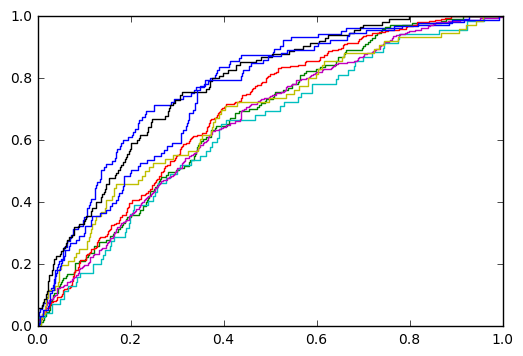

In [174]:
rocred=roccurveauc(x_val,ying_val,modelDred)

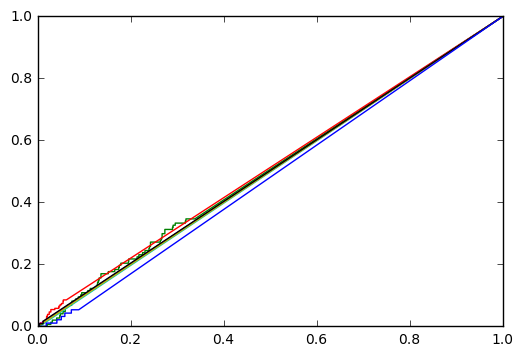

In [33]:
roc=roccurveauc(x_val,ying_val,modelDred)

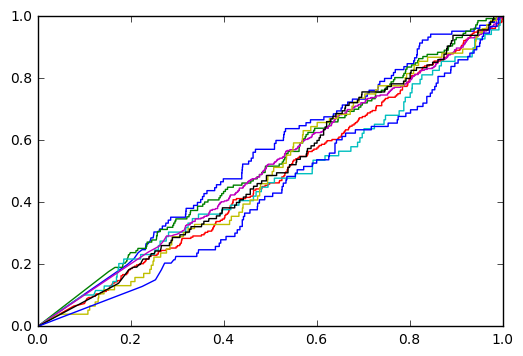

In [42]:
rocrand=roccurveauc(x_val,ying_val,modelDredrand)

In [209]:
list(zip(rocred[0],roc[0],rocrand[0]))

[(0.78452304786277927, 0.78583310483502422, 0.46929592054352132),
 (0.67002106562546127, 0.65358003819542276, 0.48322576894005465),
 (0.69328262925816331, 0.68149089836112597, 0.48944783482752252),
 (0.63751801397612629, 0.62080466958515745, 0.49710870018399189),
 (0.66046040340711187, 0.67931878872317752, 0.51946106836388961),
 (0.68351626553821732, 0.70454244908754293, 0.53735370933615445),
 (0.7757663988353537, 0.76361600268764529, 0.44064503485539913),
 (0.74111623143881211, 0.69722478238607277, 0.50126642771804064)]

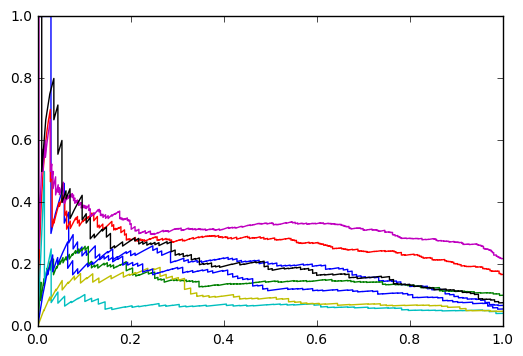

In [65]:
aa=precrec(x_val,ying_val,modelDred)

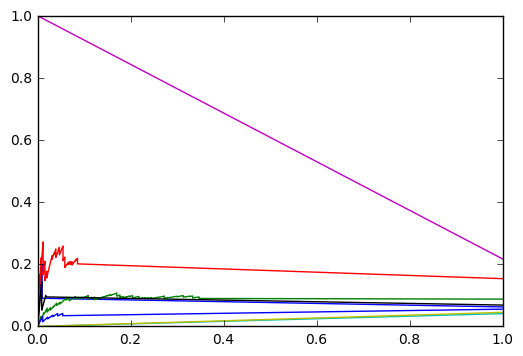

In [34]:
tunered,maxf1red = f1scoretuning(x_val,ying_val,modelDred)

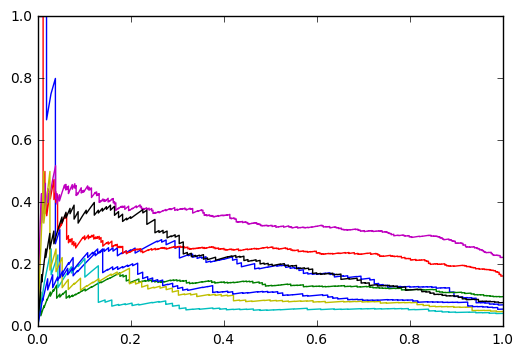

In [139]:
tune,maxf1 = f1scoretuning(x_val,ying_val,modelD)

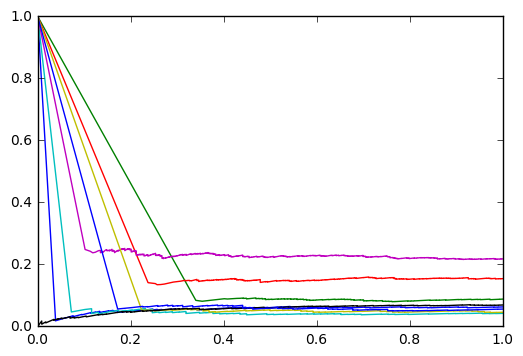

In [210]:
tunerand,maxf1rand = f1scoretuning(x_val,ying_val,modelDredrand)

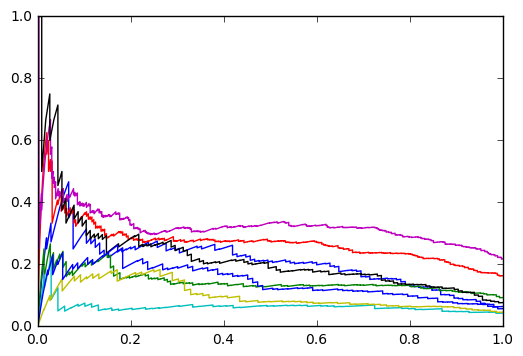

In [70]:
tuneredmod,maxf1redmod = f1scoretuning(x_val,ying_val,modelDred,bayup)

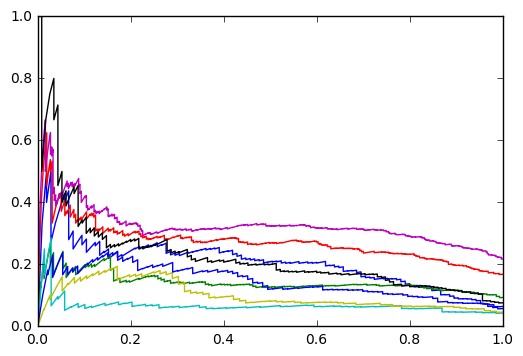

In [68]:
tuneredmodlin,maxf1redmodlin = f1scoretuning(x_val,ying_val,modelDred,bayuplin)

In [141]:
list(zip(tunered,maxf1red,ingdict,tune,maxf1))

[(0.22024544, 0.2857142857142857, 'beans', 0.26149085, 0.29235880398671099),
 (0.15697613, 0.23058252427184461, 'beef', 0.27834928, 0.22149837133550485),
 (0.21710007, 0.36399604352126608, 'chicken', 0.39397007, 0.35624394966118106),
 (0.24401847, 0.12676056338028169, 'corn', 0.17958382, 0.15652173913043479),
 (0.12526079, 0.42691029900332222, 'milk', 0.096129328, 0.43638948116560061),
 (0.20178325, 0.18469656992084432, 'pork', 0.55912691, 0.19230769230769229),
 (0.17648366,
  0.27419354838709681,
  'potatoes',
  0.36458156,
  0.29999999999999999),
 (0.47566074,
  0.21904761904761905,
  'tomatoes',
  0.21227902,
  0.20942408376963351)]

In [220]:
list(zip(tuneredmod,maxf1redmod,ingdict))

[(0.25629244705148885, 0.32234432234432236, 'beans'),
 (0.15139590436289116, 0.22844827586206895, 'beef'),
 (0.24080908972696152, 0.37731196054254007, 'chicken'),
 (0.15633399251364344, 0.12626262626262627, 'corn'),
 (0.25900511098171641, 0.4442567567567568, 'milk'),
 (0.24133996112393, 0.21782178217821782, 'pork'),
 (0.16199886456054419, 0.29156010230179025, 'potatoes'),
 (0.31548408597893179, 0.25087108013937282, 'tomatoes')]

## 5.4 Evaluating the trained/tuned model on the test sets

In [142]:
scores(ying_test,modelDred.predict(x_test),tunered)

(0.5918153200419727, 0.17385943279901356, 0.2687634024303074)

In [176]:
scores(ying_test,modelD.predict(x_test)[0],tune)

(0.6495278069254984, 0.15486614961220915, 0.2501010101010101)

In [212]:
scores(ying_test,modelDredrand.predict(x_test),tunerand)

(0.5760755508919203, 0.08866279069767442, 0.1536738978306508)

In [180]:
modelDred.evaluate(x_test, ying_test, batch_size=60, 
                verbose=1, sample_weight=None)

1453/1453 [==============================] - 0s     


[0.33288144806870412,
 0.12970488742557953,
 0.33180731893898452,
 0.18343300460046189]

In [179]:
modelD.evaluate(x_test, {'ing_output':ying_test,'cat_output':ycat_test}, batch_size=60, 
                verbose=1, sample_weight=None)

1453/1453 [==============================] - 1s     


[3.2972646888501878,
 0.319300035690326,
 13.740342806391444,
 0.25031071679803807,
 0.25516734166097738,
 0.24977823759122134,
 0.013764625631852226,
 0.12525808725042009,
 0.024531834386417314]

In [41]:
modelDredrand.evaluate(x_test, ying_test, batch_size=500, 
                verbose=1, sample_weight=None)

1453/1453 [==============================] - 0s     


[5.8332003976095974,
 0.5308810228408819,
 0.083224792917966028,
 0.14384414096659656]

## 5.5 And here's the moment of truth! Visual inspection

### 5.5.1 calculating the class scores

In [35]:
predDred=modelDred.predict(x_test, verbose=1)
predDredrand=modelDredrand.predict(x_test, verbose=1)
predD=modelD.predict(x_test, verbose=1)
#predRF=RFmodel.predict(xx_test)

1453/1453 [==============================] - 0s     


### 5.5.2 testing away

Recipe id, image path, and recipe name:
 ['116321', '116321/649354.jpg', 'Spinach and Rice Alfredo']
"Truth": ['**Spinach and Rice Alfredo', []]
Predicted: ['beef']


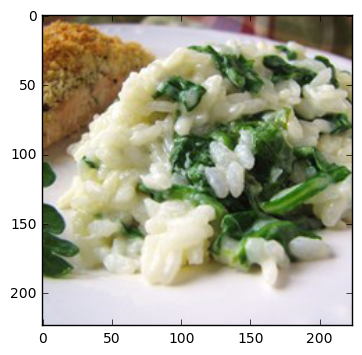

In [36]:
visualtest(38,predDred,tunered)

Predicted: ['beans']


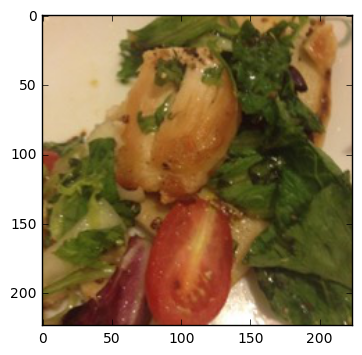

In [200]:
visualtest_man('2014-07-05-18-29-53.jpeg',modelDred,tunered)

Predicted: ['milk']


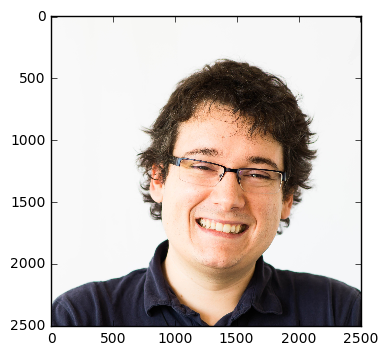

In [217]:
visualtest_man('Andrea Massari-2261.jpg',modelDred,tunered)

Predicted: ['**Shrimp Kabobs', ['beans']]


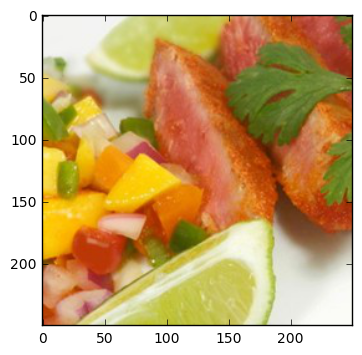

In [205]:
visualtest_man(homedir+'/103535/1156128.jpg',modelD,tune)

Predicted: ['Main Dishes', ['milk']]


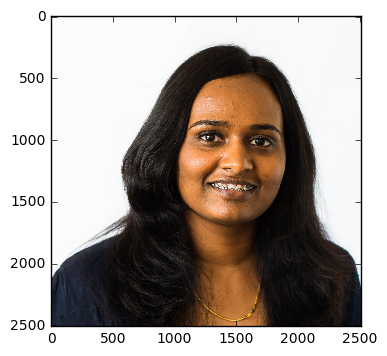

In [159]:
visualtest_man('PriyaVenkat.jpg',modelD,tune)

## 5.6 Saving and loading models

In [45]:
modelDred_json = modelDred.to_json()
with open(homedir+'/modelDred.json', "w") as json_file:
    json_file.write(modelDred_json)

modelDred.save_weights(homedir+'/modelDred.h5')

In [48]:
# later...
# load json and create model
json_file = open(homedir+'/modelDred.json', 'r')
loaded_modelDred_json = json_file.read()
json_file.close()
modelDred_loaded = model_from_json(loaded_modelDred_json)
# load weights into new model
modelDred_loaded.load_weights(homedir+'/modelDred.h5')

# 6. Scratch from here on

## 6.1 Training a Random Forest?

In [38]:
from sklearn.ensemble import RandomForestClassifier

RFmodel=RandomForestClassifier(n_estimators=30, criterion='gini', max_depth=None, min_samples_split=2, 
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                               max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False, 
                               n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)

In [37]:
xx_train=np.reshape(x_train,(len(x_train),7*7*512))
xx_val=np.reshape(x_val,(len(x_val),7*7*512))
xx_test=np.reshape(x_test,(len(x_test),7*7*512))

In [39]:
RFmodel.fit(xx_train,ying_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

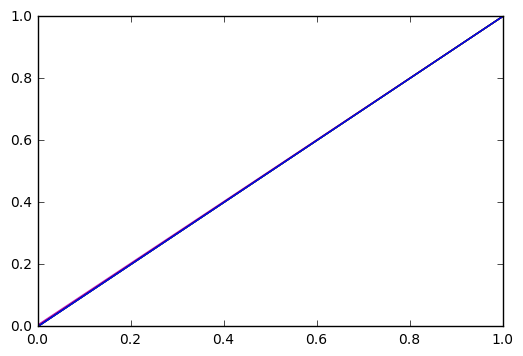

In [40]:
rocRF=roccurveauc(xx_val,ying_val,RFmodel)

In [ ]:
yhat=RFmodel.predict(xx_val)

In [195]:
RFmodel.score(xx_test,ying_test)

0.47625602202339984

## 6.2 Other models

In [ ]:
#this is literally VGG recreated by me

#img_width, img_height = 250, 250
img_width, img_height = 224, 224



inputs = Input(shape=(img_width, img_height,3))

xo=ZeroPadding2D()(inputs)
xo=Convolution2D(64, 3, 3, activation='relu')(xo)
xo=ZeroPadding2D()(xo)
xo=Convolution2D(64, 3, 3, activation='relu')(xo)
xo=MaxPooling2D((2,2), strides=(2,2))(xo)

xo=ZeroPadding2D()(xo)
xo=Convolution2D(128, 3, 3, activation='relu')(xo)
xo=ZeroPadding2D()(xo)
xo=Convolution2D(128, 3, 3, activation='relu')(xo)
xo=MaxPooling2D((2,2), strides=(2,2))(xo)

xo=ZeroPadding2D()(xo)
xo=Convolution2D(256, 3, 3, activation='relu')(xo)
xo=ZeroPadding2D()(xo)
xo=Convolution2D(256, 3, 3, activation='relu')(xo)
xo=ZeroPadding2D()(xo)
xo=Convolution2D(256, 3, 3, activation='relu')(xo)
xo=MaxPooling2D((2,2), strides=(2,2))(xo)

xo=ZeroPadding2D()(xo)
xo=Convolution2D(512, 3, 3, activation='relu')(xo)
xo=ZeroPadding2D()(xo)
xo=Convolution2D(512, 3, 3, activation='relu')(xo)
xo=ZeroPadding2D()(xo)
xo=Convolution2D(512, 3, 3, activation='relu')(xo)
xo=MaxPooling2D((2,2), strides=(2,2))(xo)

xo=ZeroPadding2D()(xo)
xo=Convolution2D(512, 3, 3, activation='relu')(xo)
xo=ZeroPadding2D()(xo)
xo=Convolution2D(512, 3, 3, activation='relu')(xo)
xo=ZeroPadding2D()(xo)
xo=Convolution2D(512, 3, 3, activation='relu')(xo)
xo=MaxPooling2D((2,2), strides=(2,2))(xo)

xo=Flatten()(xo)
xo=Dense(4096, activation='relu')(xo)
xo=Dropout(0.5)(xo)
xo=Dense(4096, activation='relu')(xo)
xo=Dropout(0.5)(xo)
preds=Dense(1000, activation='softmax')(xo)

model = Model(input=inputs, output=preds)

model.load_weights("vgg16_weights_tf_dim_ordering_tf_kernels.h5")

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])


In [10]:
#ARCH-D from Chen et al

img_width, img_height = 250, 250
#img_width, img_height = 224, 224

inputs = Input(shape=(img_width, img_height,3))

xo=ZeroPadding2D()(inputs)
xo=Convolution2D(64, 3, 3, activation='relu')(xo)
xo=ZeroPadding2D()(xo)
xo=Convolution2D(64, 3, 3, activation='relu')(xo)
xo=MaxPooling2D((2,2), strides=(2,2))(xo)

xo=ZeroPadding2D()(xo)
xo=Convolution2D(128, 3, 3, activation='relu')(xo)
xo=ZeroPadding2D()(xo)
xo=Convolution2D(128, 3, 3, activation='relu')(xo)
xo=MaxPooling2D((2,2), strides=(2,2))(xo)

xo=ZeroPadding2D()(xo)
xo=Convolution2D(256, 3, 3, activation='relu')(xo)
xo=ZeroPadding2D()(xo)
xo=Convolution2D(256, 3, 3, activation='relu')(xo)
xo=ZeroPadding2D()(xo)
xo=Convolution2D(256, 3, 3, activation='relu')(xo)
xo=MaxPooling2D((2,2), strides=(2,2))(xo)

xo=ZeroPadding2D()(xo)
xo=Convolution2D(512, 3, 3, activation='relu')(xo)
xo=ZeroPadding2D()(xo)
xo=Convolution2D(512, 3, 3, activation='relu')(xo)
xo=ZeroPadding2D()(xo)
xo=Convolution2D(512, 3, 3, activation='relu')(xo)
xo=MaxPooling2D((2,2), strides=(2,2))(xo)

xo=ZeroPadding2D()(xo)
xo=Convolution2D(512, 3, 3, activation='relu')(xo)
xo=ZeroPadding2D()(xo)
xo=Convolution2D(512, 3, 3, activation='relu')(xo)
xo=ZeroPadding2D()(xo)
xo=Convolution2D(512, 3, 3, activation='relu')(xo)
xo=MaxPooling2D((2,2), strides=(2,2))(xo)

xo=Flatten()(xo)
xo=Dense(4096, activation='relu')(xo)
xo=Dropout(0.5)(xo)
xoc=Dense(4096, activation='relu')(xo)
xoc=Dropout(0.5)(xoc)
xoi=Dense(1024, activation='relu')(xo)
xoi=Dropout(0.5)(xoi)

predsc=Dense(numb_ctg, activation='softmax',name='cat_output')(xoc)
predsi=Dense(numb_ing, activation='softmax',name='ing_output')(xoi)

modelD = Model(input=inputs, output=[predsi,predsc])

#model.load_weights("vgg16_weights_tf_dim_ordering_tf_kernels.h5")
#modelD.load_weights("vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")

#model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

modelD.compile(optimizer='rmsprop',
              loss={'ing_output': 'categorical_crossentropy', 'cat_output': 'binary_crossentropy'},
              loss_weights={'ing_output': 1., 'cat_output': 0.5},metrics=['accuracy'])


ValueError: You are trying to load a weight file containing 13 layers into a model with 18 layers.

In [24]:
model.input

<tf.Tensor 'input_2:0' shape=(?, 250, 250, 3) dtype=float32>

In [25]:
model.output

<tf.Tensor 'Softmax_1:0' shape=(?, 1000) dtype=float32>

## 6.3 here I was concerned with class weights to fix imbalance using complex decision trees or class weights but I've adopted a different approach

In [65]:
def histo(bin_list,pathlist):
    histog={}
    for i,b in enumerate(bin_list):
        c=""
        for j in b:
            c+=str(int(j))
        if c in histog.keys():
            histog[c][0]+=1
            histog[c][1]+=[pathlist[i]]
        else:
            histog[c]=[1,[pathlist[i]]]
    return histog

def balance(list1):
    histog=np.zeros(len(list1[0]))
    for b in list1:
        histog+=np.array([int(bb) for bb in b])
    return [ sorted(range(len(histog)), key=lambda k: min(histog[k],len(list1)-histog[k])),histog/len(list1)]

In [80]:
initlist=[ii[1] for ii in img_labels.values()]
initlist_catg=[ii[2] for ii in img_labels.values()]
hist_init=histo(initlist, list(img_labels.keys()))
hist_init_catg=histo(initlist_catg, list(img_labels.keys()))
cl_w_ing={i:1/ii for i,ii in enumerate(balance(initlist)[1]*len(initlist))}
cl_w_catg={i:1/ii for i,ii in enumerate(balance(initlist_catg)[1]*len(initlist_catg))}

In [82]:
cl_w_ing

{0: 0.00024009603841536616}

In [401]:
np.mean(balance(initlist)[1])

0.13321580961157076

In [402]:
balance(initlist)

[[0, 4, 1, 3, 2],
 array([ 0.05058194,  0.08343516,  0.26368717,  0.20647449,  0.06190028])]

In [435]:
len(initlist)

49919

In [513]:
#this is just to keep an eye on how balanced our data set is
np.mean(balance([img_labels[ii][1] for ii in images_filter])[1])

0.28302325581395349

In [754]:
cl_w_catg[465]=0.

In [176]:
normcat=sum(list(cl_w_catg.values()))
cl_w_catg={ii:cl_w_catg[ii]/normcat for ii in cl_w_catg.keys()}

In [171]:
norming=sum(list(cl_w_ing.values()))
cl_w_ing={ii:cl_w_ing[ii]/norming for ii in cl_w_ing.keys()}

In [172]:
cl_w_ing

{0: 0.37527828437000871, 1: 0.11876400278680159, 2: 0.50595771284318969}

In [14]:
def treefy_init(initlist,ing):
    len_list=len(initlist)
    if len_list==0:
        return
    imb=balance(initlist)
    distr=set(imb[1])
    if distr=={0.,1.} or len(distr)==1:
        return initlist[:1]
    else:
        templist1=[]
        templist2=[]
        for ii in initlist:
            if ii[ing]==0.:
                templist1+=[ii]
            else:
                templist2+=[ii]     
        return [treefy(templist1),treefy(templist2)]
    
def treefy(initlist):
    len_list=len(initlist)
    if len_list==0:
        return
    imb=balance(initlist)
    distr=set(imb[1])
    if distr=={0.,1.} or len(distr)==1:
        return initlist[:1]
    else:
        templist1=[]
        templist2=[]
        jj=0
        dec=imb[0][0]
        while imb[1][dec] in {0.,1.}:
            jj+=1
            dec=imb[0][jj]
        for ii in initlist:
            if ii[dec]==0.:
                templist1+=[ii]
            else:
                templist2+=[ii]     
        return [treefy(templist1),treefy(templist2)]
    
    
#this is for debugging    
def treefy_deb(initlist):
    len_list=len(initlist)
    if len_list==0:
        return
    imb=balance(initlist)
    distr=set(imb[1])
    if distr=={0.,1.} or len(distr)==1:
        return initlist[:1]
    else:
        templist1=[]
        templist2=[]
        jj=0
        dec=imb[0][0]
        while imb[1][dec] in {0.,1.}:
            jj+=1
            dec=imb[0][jj]
        for ii in initlist:
            if ii[dec]==0.:
                templist1+=[ii]
            else:
                templist2+=[ii]     
        return [templist1,templist2]

In [124]:
#in this block we are computing the splitting trees for the 10 most imbalanced ingredient classes
tree_ing={}
count=0
for ii in balance(initlist)[0][:3]:
    print("Calculating tree #",count+1)
    tree_ing[ii]=treefy_init(initlist,ii)
    count+=1

Calculating tree # 1
Calculating tree # 2
Calculating tree # 3


In [22]:
#here we rotate among the 10 tress created above, run randomly down these binary trees to pick 
#an ingredient composition and then a random image (50k times)
bal_data=[]
bal_data_expl=[]
for j in range(len(initlist)):
    temp=tree_ing[list(tree_ing.keys())[j%len(tree_ing)]]
    while len(temp)<3:
        temp=temp[random.randint(0,len(temp)-1)]
    bal_data_expl+=[temp]
    str_temp=""
    for vals in temp:
        str_temp+=str(int(vals))
    pathtemp=hist_init[str_temp][1]
    ltemp=len(pathtemp)
    bal_data+=[pathtemp[random.randint(0,ltemp-1)]]

In [24]:
np.mean(balance(bal_data_expl)[1])

0.50131543803418799

In [26]:
balance(bal_data_expl)

[[1, 0, 2], array([ 0.50046074,  0.50346554,  0.50002003])]

## 6.4 Here we load and explore h5 file with weights

In [135]:
import h5py
weight_file=h5py.File('','r')

In [129]:
aa=weight_file.get('/')

In [133]:
nG=np.array(weight_file.get('/'))

In [144]:
for i in weight_file.get('/'):
    print(i)

block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
fc1
fc2
flatten
predictions


In [140]:
weight_file.get('block1_conv1').get('block1_conv1_W_1:0')

<HDF5 dataset "block1_conv1_W_1:0": shape (3, 3, 3, 64), type "<f4">

In [145]:
np.array(weight_file.get('block1_conv1').get('block1_conv1_W_1:0')).shape

(3, 3, 3, 64)

In [148]:
set(weight_file.get('predictions'))

{'predictions_W_1:0', 'predictions_b_1:0'}

In [155]:
weight_file.get('predictions').get('predictions_W_1:0')[0,3]

0.0014801123

## 6.5 Scratchy scratch

In [ ]:
#Jeremy: check out tensorboard for visualizations!!

In [15]:
#here I'm splitting training and validation sets randomly, plus I'm converting to numpy arrays
#xret_trainval, xret_test, ycy_trainval, ycy_test = train_test_split(xret, ycy, test_size=0.1, random_state=1)
#xret_train, xret_val, ycy_train, ycy_val = train_test_split(xret_trainval, ycy_trainval, test_size=0.1, random_state=1)
#x_train,x_val,x_test=np.array([ii[0] for ii in xret_train]),np.array([ii[0] for ii in xret_val]),np.array([ii[0] for ii in xret_test])
#ret_train,ret_val,ret_test=np.array([ii[1:] for ii in xret_train]),np.array([ii[1:] for ii in xret_val]),np.array([ii[1:] for ii in xret_test])
#ying_train,ying_val,ying_test=np.array([ii[:numb_ing] for ii in ycy_train]),np.array([ii[:numb_ing] for ii in ycy_val]),np.array([ii[:numb_ing] for ii in ycy_test])
#ycat_train,ycat_val,ycat_test=np.array([ii[numb_ing:] for ii in ycy_train]),np.array([ii[numb_ing:] for ii in ycy_val]),np.array([ii[numb_ing:] for ii in ycy_test])